In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import string
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load dataset
df = pd.read_csv(r"C:\Emotion Training\emotions.csv")

In [4]:
# Handle missing values and duplicates
print("Missing values before handling:")
print(df.isnull().sum())
df.dropna(inplace=True)
df.drop_duplicates(subset='text', inplace=True)

# Show class distribution
print("\nClass distribution:")
print(df['label'].value_counts())

Missing values before handling:
text     0
label    0
dtype: int64

Class distribution:
label
1    135030
0    118511
3     54777
4     43629
2     29468
5     12407
Name: count, dtype: int64


In [5]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

In [6]:
# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Encode emotion labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Split data
X = df['cleaned_text']
y = df['encoded_label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Limit training size for speed
X_train_tfidf = X_train_tfidf[:20000]
y_train = y_train[:20000]

In [7]:
# Evaluate SVM with different kernels
def evaluate_svm(kernel_type):
    print(f"\nTraining and evaluating SVM with {kernel_type} kernel...")
    model = SVC(kernel=kernel_type, random_state=42)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Convert class names to strings
    class_names = [str(cls) for cls in label_encoder.classes_]

    acc = accuracy_score(y_test, y_pred)
    report_dict = classification_report(
        y_test, y_pred, target_names=class_names, output_dict=True
    )

    print(f"\nSVM with {kernel_type} kernel:")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {kernel_type} kernel')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return acc, report_dict, model


Training and evaluating SVM with linear kernel...

SVM with linear kernel:
Accuracy: 0.8745
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     23702
           1       0.88      0.91      0.90     27006
           2       0.81      0.68      0.74      5894
           3       0.89      0.85      0.87     10956
           4       0.84      0.85      0.85      8726
           5       0.73      0.77      0.75      2481

    accuracy                           0.87     78765
   macro avg       0.84      0.83      0.83     78765
weighted avg       0.87      0.87      0.87     78765



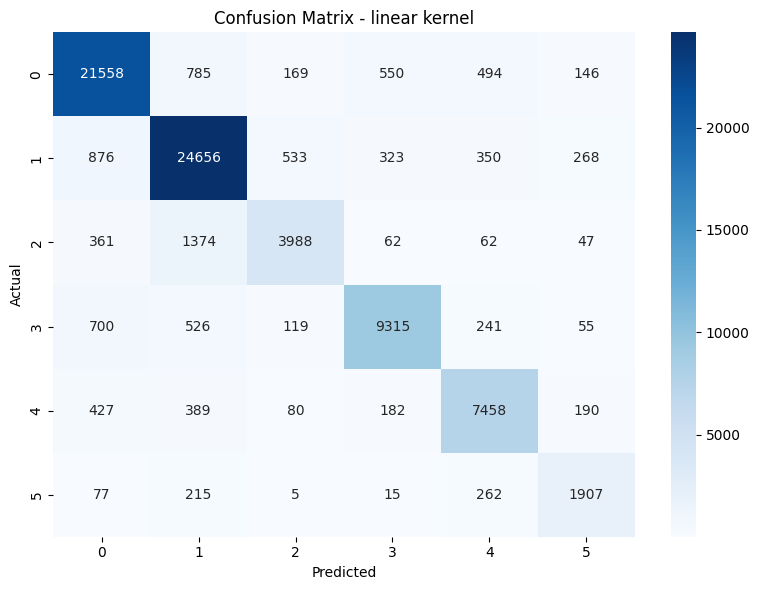


Training and evaluating SVM with poly kernel...

SVM with poly kernel:
Accuracy: 0.6443
              precision    recall  f1-score   support

           0       0.83      0.75      0.79     23702
           1       0.52      0.98      0.68     27006
           2       0.91      0.14      0.24      5894
           3       0.95      0.30      0.45     10956
           4       0.94      0.24      0.39      8726
           5       0.86      0.13      0.23      2481

    accuracy                           0.64     78765
   macro avg       0.84      0.42      0.46     78765
weighted avg       0.76      0.64      0.60     78765



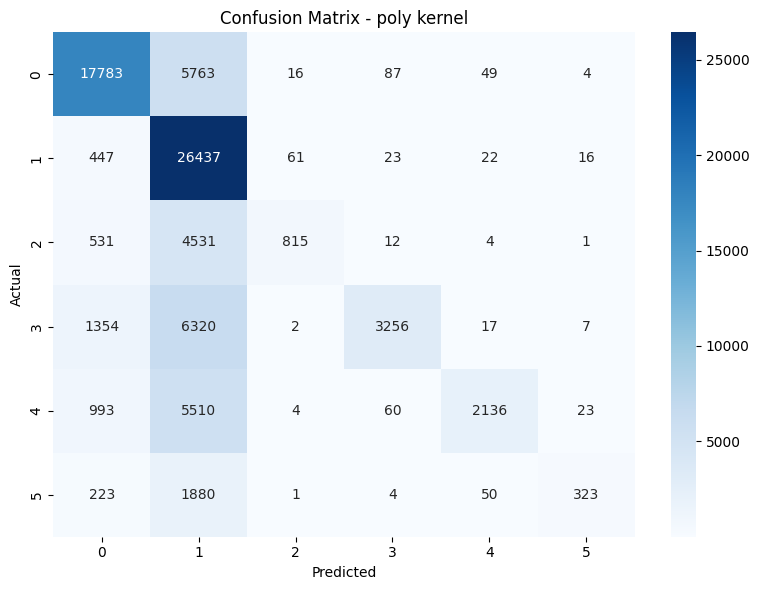


Training and evaluating SVM with rbf kernel...

SVM with rbf kernel:
Accuracy: 0.8561
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     23702
           1       0.82      0.93      0.88     27006
           2       0.84      0.57      0.68      5894
           3       0.91      0.80      0.85     10956
           4       0.86      0.79      0.82      8726
           5       0.78      0.60      0.68      2481

    accuracy                           0.86     78765
   macro avg       0.85      0.77      0.80     78765
weighted avg       0.86      0.86      0.85     78765



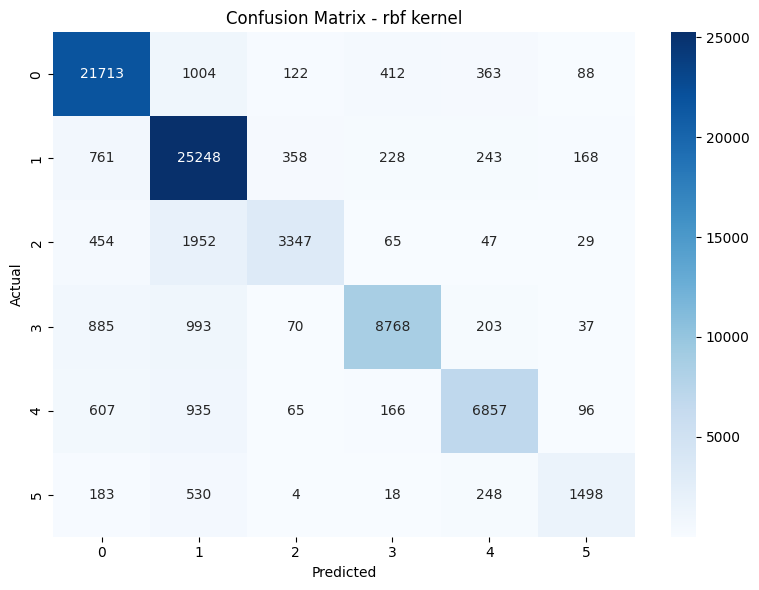


Training and evaluating SVM with sigmoid kernel...

SVM with sigmoid kernel:
Accuracy: 0.8737
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     23702
           1       0.88      0.91      0.90     27006
           2       0.82      0.67      0.73      5894
           3       0.89      0.85      0.87     10956
           4       0.84      0.86      0.85      8726
           5       0.75      0.76      0.75      2481

    accuracy                           0.87     78765
   macro avg       0.84      0.83      0.83     78765
weighted avg       0.87      0.87      0.87     78765



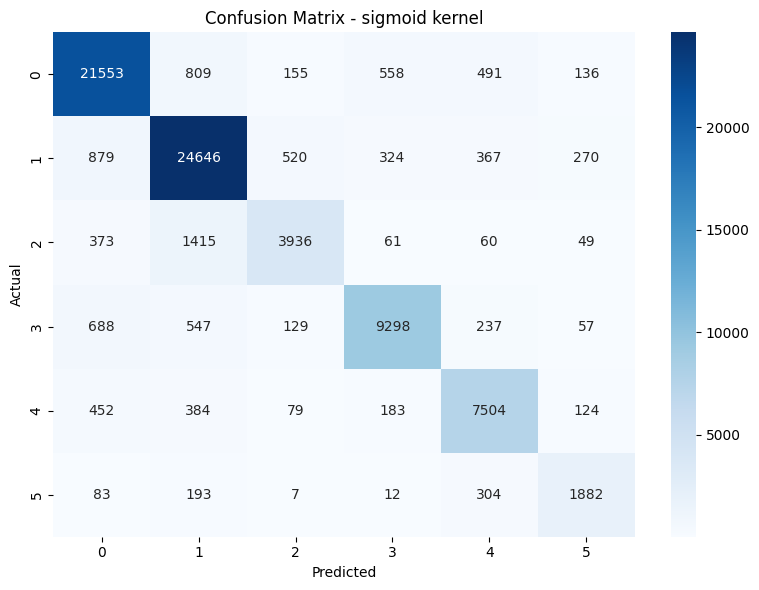

In [8]:
# Try multiple kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {}
best_model = None
best_kernel = ""
best_acc = 0

for kernel in kernels:
    accuracy, report, model = evaluate_svm(kernel)
    results[kernel] = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }
    if accuracy > best_acc:
        best_acc = accuracy
        best_model = model
        best_kernel = kernel



Performance comparison across kernels:
         accuracy  precision    recall  f1-score
linear   0.874525   0.873999  0.874525  0.873592
poly     0.644322   0.761073  0.644322  0.602744
rbf      0.856104   0.857393  0.856104  0.852399
sigmoid  0.873726   0.873040  0.873726  0.872630


<Figure size 1000x600 with 0 Axes>

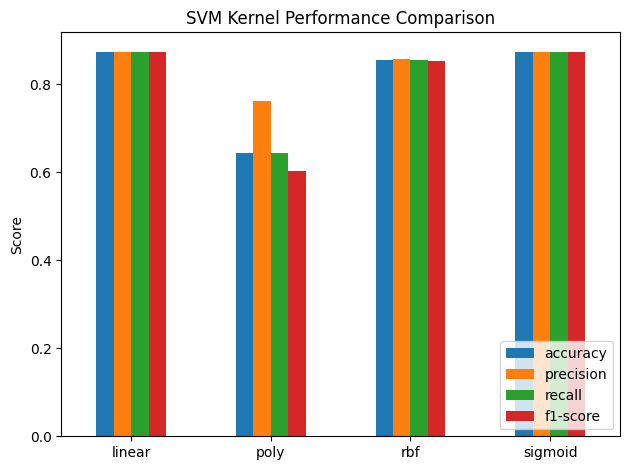


 Best performing kernel: linear


In [10]:
# Kernel Performance Summary
results_df = pd.DataFrame(results).T
print("\nPerformance comparison across kernels:")
print(results_df)

plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', y=['accuracy', 'precision', 'recall', 'f1-score'],
                title='SVM Kernel Performance Comparison')
plt.xticks(rotation=0)
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f"\n Best performing kernel: {best_kernel}")

In [11]:
# Save the best model and vectorizer
joblib.dump(best_model, 'best_svm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("\n Model, vectorizer, and label encoder saved!")


 Model, vectorizer, and label encoder saved!
